In [1]:
import sys
sys.path.append("../")
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
from lora_diffusion import tune_lora_scale, patch_pipe
import open_clip
from PIL import Image
from disen_net import Image_adapter
import os
from visualization import joint_visualization
model_id = "/DATA/DATANAS1/zhangyip/models/stable-diffusion-2-1-base"

with torch.no_grad():
    pipe = StableDiffusionPipeline.from_pretrained(model_id).to("cuda")
    img_model, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')
    img_model = img_model.to("cuda")

/home/chenhong/anaconda3/envs/diffusion/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [2]:
name, prompt_class = ("dog8", "dog8")
unique_token = name+ "</w>"
cpt_list = ["my_base", "my_base_global0.01", "global0.01disen0.001", "no_adapter" ]
cpt = cpt_list[2]
dir_path = "./output_dreambooth/our_versions/" + name + "/" + cpt +"/checkpoint"
print(dir_path)
patch_pipe(
    pipe,
    os.path.join(dir_path, "lora_weight_e219_s1100.pt"),
    patch_text=False,
    patch_ti=False,
    patch_unet=True,
)
adapter = Image_adapter().to("cuda")
info = torch.load(os.path.join(dir_path, "lora_weight_e219_s1100.img_adapter.pt"))
adapter.load_state_dict(info)
ref_image = preprocess(Image.open( os.path.join("/DATA/DATANAS1/chenhong/diffusion_research/dreambooth_data", name, "01.jpg") )).unsqueeze(0).to("cuda")

./output_dreambooth/our_versions/dog8/global0.01disen0.001/checkpoint
LoRA : Patching Unet


a dog8</w> dog8 is playing with a butterfly in the red flowers


  0%|          | 0/50 [00:00<?, ?it/s]

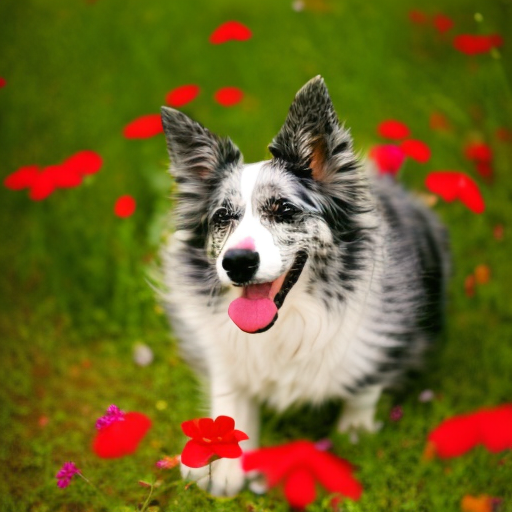

In [5]:
torch.manual_seed(16)
tune_lora_scale(pipe.unet, 1.0)
# test_prompt = "a backpack in front of the blue house"
test_prompt = "a " + unique_token  +" "+ prompt_class + " is playing with a butterfly in the red flowers"
print(test_prompt)
image = joint_visualization(pipe, img_model, test_prompt, ref_image, guidance=7.0, eta=0.0, img_adapter=adapter, step=50, num_images_per_prompt = 1)[0]
image
# path = '/DATA/DATANAS1/zhangyip/imgs/backpcak/2'
# os.makedirs(path, exist_ok= True)
# image.save(os.path.join('/DATA/DATANAS1/zhangyip/imgs','backpack','2','DisenBooth.jpg'))

In [ ]:
test_prompt = "a " + unique_token  +" "+ prompt_class + " is running beside an airplane"
print(test_prompt)
image = joint_visualization(pipe, img_model, test_prompt, ref_image, guidance=7.0, eta=0.0, img_adapter=adapter, step=50, num_images_per_prompt = 1)[0]
image

a dog8</w> dog8 is running beside an airplane


  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
# test_prompt = "a " + unique_token  +" "+ prompt_class + " beside a blue river"
# print(test_prompt)
# image = joint_visualization(pipe, img_model, test_prompt, ref_image, guidance=7.0, eta=0.0, img_adapter=adapter, step=50, num_images_per_prompt = 1)[0]
# image